In [1]:
%matplotlib inline
import matplotlib.pyplot
import matplotlib.colors
import numpy
import os
import math
import string
import json
import pandas
import scipy
import scipy.spatial
import scipy.stats
import tqdm
import networkx
import random
import sklearn.linear_model
import psycopg2
import configparser
import sqlalchemy
import seaborn

In [2]:
matplotlib.pyplot.rcParams["font.family"] = 'Georgia'

In [3]:
config = configparser.ConfigParser()
#config.read(args.pgconf)
config.read("db.conf")

['db.conf']

In [4]:
dbname = config['database']['dbname']
user = config['database']['user']
password = config['database']['password']
host = config['database']['host']
port = config['database']['port']
conn = psycopg2.connect(f'dbname={dbname} user={user} password={password} host={host} port={port}')
read_cursor = conn.cursor()
write_cursor = conn.cursor()
engine = sqlalchemy.create_engine(
    f"postgresql+psycopg2://{user}:{password}@{host}:5432/{dbname}")

In [5]:
language_family_columns = [
     'indo_european',
 'austronesian',
 'trans_new_guinea',
 'sino_tibetan',
 'kra_dai',
    'niger_congo',
 'australian_aboriginal',
 'afro_asiatic',
 'nilo_saharan',
 'oto_manguean',
 'austroasiatic',
 'dravidian',
 'tupian',
 'atlantic_congo',
 'pama_nyungan',
 'arawakan',
 'mande']
extra_families = ['unclassified', 'unrecorded',  'all_human']

In [6]:
colorscheme = matplotlib.pyplot.cm.RdBu_r

In [7]:
nice_language_family_names = {
 'indo_european': 'Indo-European',
 'austronesian': 'Austronesian',
 'trans_new_guinea': 'Trans New Guinea',
 'sino_tibetan': 'Sino-Tibetan',
 'kra_dai' : 'Kra-Dai',
 'niger_congo': 'Niger-Congo',
 'australian_aboriginal': 'Australian aboriginal',
 'afro_asiatic': 'Afro-Asiatic',
 'nilo_saharan': 'Nilo-Saharan',
 'oto_manguean': 'Oto-Meanguean',
 'austroasiatic': 'Austroasiatic',
 'dravidian': 'Dravidian',
 'tupian': 'Tupian',
 'atlantic_congo': 'Atlantic-Congo',
 'pama_nyungan': 'Pama-Nyungan',
 'arawakan': 'Arawakn',
 'mande': 'Mande',
 'unclassified': 'Unclassified',
    'unrecorded': 'Unrecorded',
    'all_human': 'All languages'
}

metrics = ['y_equals_x_proportion_correct', 
           'global_padic_linear_proportion_correct',  'global_siegel_proportion_correct',
          'local_padic_linear_proportion_correct',
           'local_euclidean_siegel_proportion_correct',
          'hybrid_siegel_proportion_correct'
          ]

metric_renaming = {
    'y_equals_x_proportion_correct': 'Y Equals X',
    'global_padic_linear_proportion_correct': 'Global p-adic',
    'global_siegel_proportion_correct': 'Global Siegel',
    'local_padic_linear_proportion_correct': 'Local P-adic linear',
    'local_euclidean_siegel_proportion_correct': 'Local Siegel',
    'hybrid_siegel_proportion_correct': 'Hybrid'
}
renamed_metrics = [metric_renaming.get(m,m) for m in metrics]

In [8]:
by_language = pandas.read_sql("""
select * 
  from machine_learning_morphology_summary_by_language 
  left join language_family 
  on (machine_learning_morphology_summary_by_language.language = language_family.iso_639_3_code)""", engine)

languages_with_no_recorded_family = list(by_language[by_language.indo_european.isnull()].language)
by_language.fillna(False, inplace=True)
languages_not_elsewhere_classified = list(by_language[~by_language[language_family_columns].any(axis=1)].language)
by_language['all_human'] = True
by_language['unrecorded'] = by_language.language.isin(languages_with_no_recorded_family)
by_language['unclassified'] = by_language.language.isin(languages_not_elsewhere_classified)

renamed = by_language.rename(columns=metric_renaming)

In [9]:
proportion_correct_columns = [x for x in by_language.columns if x.endswith('proportion_correct')]
proportion_correct_columns

['global_padic_linear_proportion_correct',
 'global_siegel_proportion_correct',
 'hybrid_siegel_proportion_correct',
 'local_euclidean_siegel_proportion_correct',
 'local_padic_linear_proportion_correct',
 'y_equals_x_proportion_correct']

In [10]:
by_language[proportion_correct_columns].describe().rename(columns=metric_renaming)

,Global p-adic,Global Siegel,Hybrid,Local Siegel,Local P-adic linear,Y Equals X
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,0.120988,0.016428,0.066770,0.085028,0.108755,0.133228
std,0.127187,0.074784,0.074573,0.084896,0.093834,0.078643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.008197
25%,0.000000,0.000000,0.016393,0.025316,0.038462,0.073684
50%,0.090909,0.000000,0.043478,0.059701,0.086957,0.116071
75%,0.223684,0.000000,0.095238,0.120000,0.153846,0.176991
max,0.592593,0.592593,0.670103,0.592593,0.670103,0.523256


In [11]:
average_correct_by_language_family = pandas.DataFrame({ nice_language_family_names[x]: 
by_language[by_language[x]][proportion_correct_columns].mean()
for x in (language_family_columns + extra_families)
}).T.rename(columns=metric_renaming)
average_with_stddev_correct_by_language_family = pandas.DataFrame(
    { nice_language_family_names[x]: 
     by_language[by_language[x]][proportion_correct_columns].mean().map(lambda x: '%.3f' % (x,))
     +
     by_language[by_language[x]][proportion_correct_columns].std().map(lambda x: '+/-%.3f' % (x,))
        for x in (language_family_columns + extra_families)
}).T.rename(columns=metric_renaming)

average_with_stddev_correct_by_language_family

,Global p-adic,Global Siegel,Hybrid,Local Siegel,Local P-adic linear,Y Equals X
Indo-European,0.105+/-0.139,0.056+/-0.136,0.135+/-0.126,0.109+/-0.117,0.154+/-0.126,0.127+/-0.080
Austronesian,0.203+/-0.141,0.038+/-0.118,0.103+/-0.084,0.142+/-0.102,0.172+/-0.103,0.192+/-0.082
Trans New Guinea,0.124+/-0.109,0.011+/-0.057,0.063+/-0.052,0.084+/-0.055,0.092+/-0.061,0.120+/-0.037
Sino-Tibetan,0.174+/-0.131,0.027+/-0.087,0.087+/-0.077,0.112+/-0.092,0.130+/-0.097,0.155+/-0.083
Kra-Dai,0.397+/-0.028,0.000+/-0.000,0.224+/-0.050,0.293+/-0.031,0.309+/-0.042,0.352+/-0.004
Niger-Congo,0.093+/-0.089,0.005+/-0.037,0.033+/-0.042,0.048+/-0.054,0.077+/-0.071,0.103+/-0.060
Australian aboriginal,0.033+/-0.071,0.000+/-0.000,0.027+/-0.030,0.030+/-0.043,0.038+/-0.038,0.058+/-0.034
Afro-Asiatic,0.039+/-0.077,0.000+/-0.002,0.037+/-0.042,0.040+/-0.035,0.051+/-0.051,0.107+/-0.063
Nilo-Saharan,0.076+/-0.105,0.000+/-0.002,0.039+/-0.043,0.054+/-0.057,0.078+/-0.062,0.120+/-0.074
Oto-Meanguean,0.145+/-0.124,0.003+/-0.019,0.070+/-0.044,0.112+/-0.060,0.125+/-0.067,0.171+/-0.057


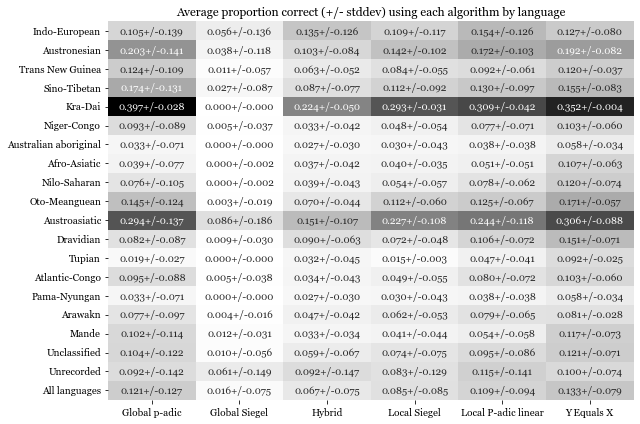

In [12]:
fig, ax = matplotlib.pyplot.subplots(figsize=(9,6))
seaborn.heatmap(average_correct_by_language_family, ax=ax, annot=average_with_stddev_correct_by_language_family,
               fmt='s', cmap='Greys', cbar=False)

ax.set_title("Average proportion correct (+/- stddev) using each algorithm by language")
fig.tight_layout()
fig.savefig("heatmap-of-proportion-correct.png")

In [13]:
winning_method_by_family = average_correct_by_language_family.idxmax(axis=1)
winning_method_by_family

Indo-European            Local P-adic linear
Austronesian                   Global p-adic
Trans New Guinea               Global p-adic
Sino-Tibetan                   Global p-adic
Kra-Dai                        Global p-adic
Niger-Congo                       Y Equals X
Australian aboriginal             Y Equals X
Afro-Asiatic                      Y Equals X
Nilo-Saharan                      Y Equals X
Oto-Meanguean                     Y Equals X
Austroasiatic                     Y Equals X
Dravidian                         Y Equals X
Tupian                            Y Equals X
Atlantic-Congo                    Y Equals X
Pama-Nyungan                      Y Equals X
Arawakn                           Y Equals X
Mande                             Y Equals X
Unclassified                      Y Equals X
Unrecorded               Local P-adic linear
All languages                     Y Equals X
dtype: object

In [14]:
comparison_pairs = [( 'global_padic_linear_proportion_correct', 'y_equals_x_proportion_correct'),
                    ('local_padic_linear_proportion_correct', 'y_equals_x_proportion_correct'),
                    ('global_padic_linear_proportion_correct', 'global_siegel_proportion_correct'),
                    ('local_padic_linear_proportion_correct', 'local_euclidean_siegel_proportion_correct')
                   ]

number_of_experiments = len(language_family_columns + extra_families) * len(comparison_pairs)
bonferroni = lambda p: 1 - (1-p)**number_of_experiments

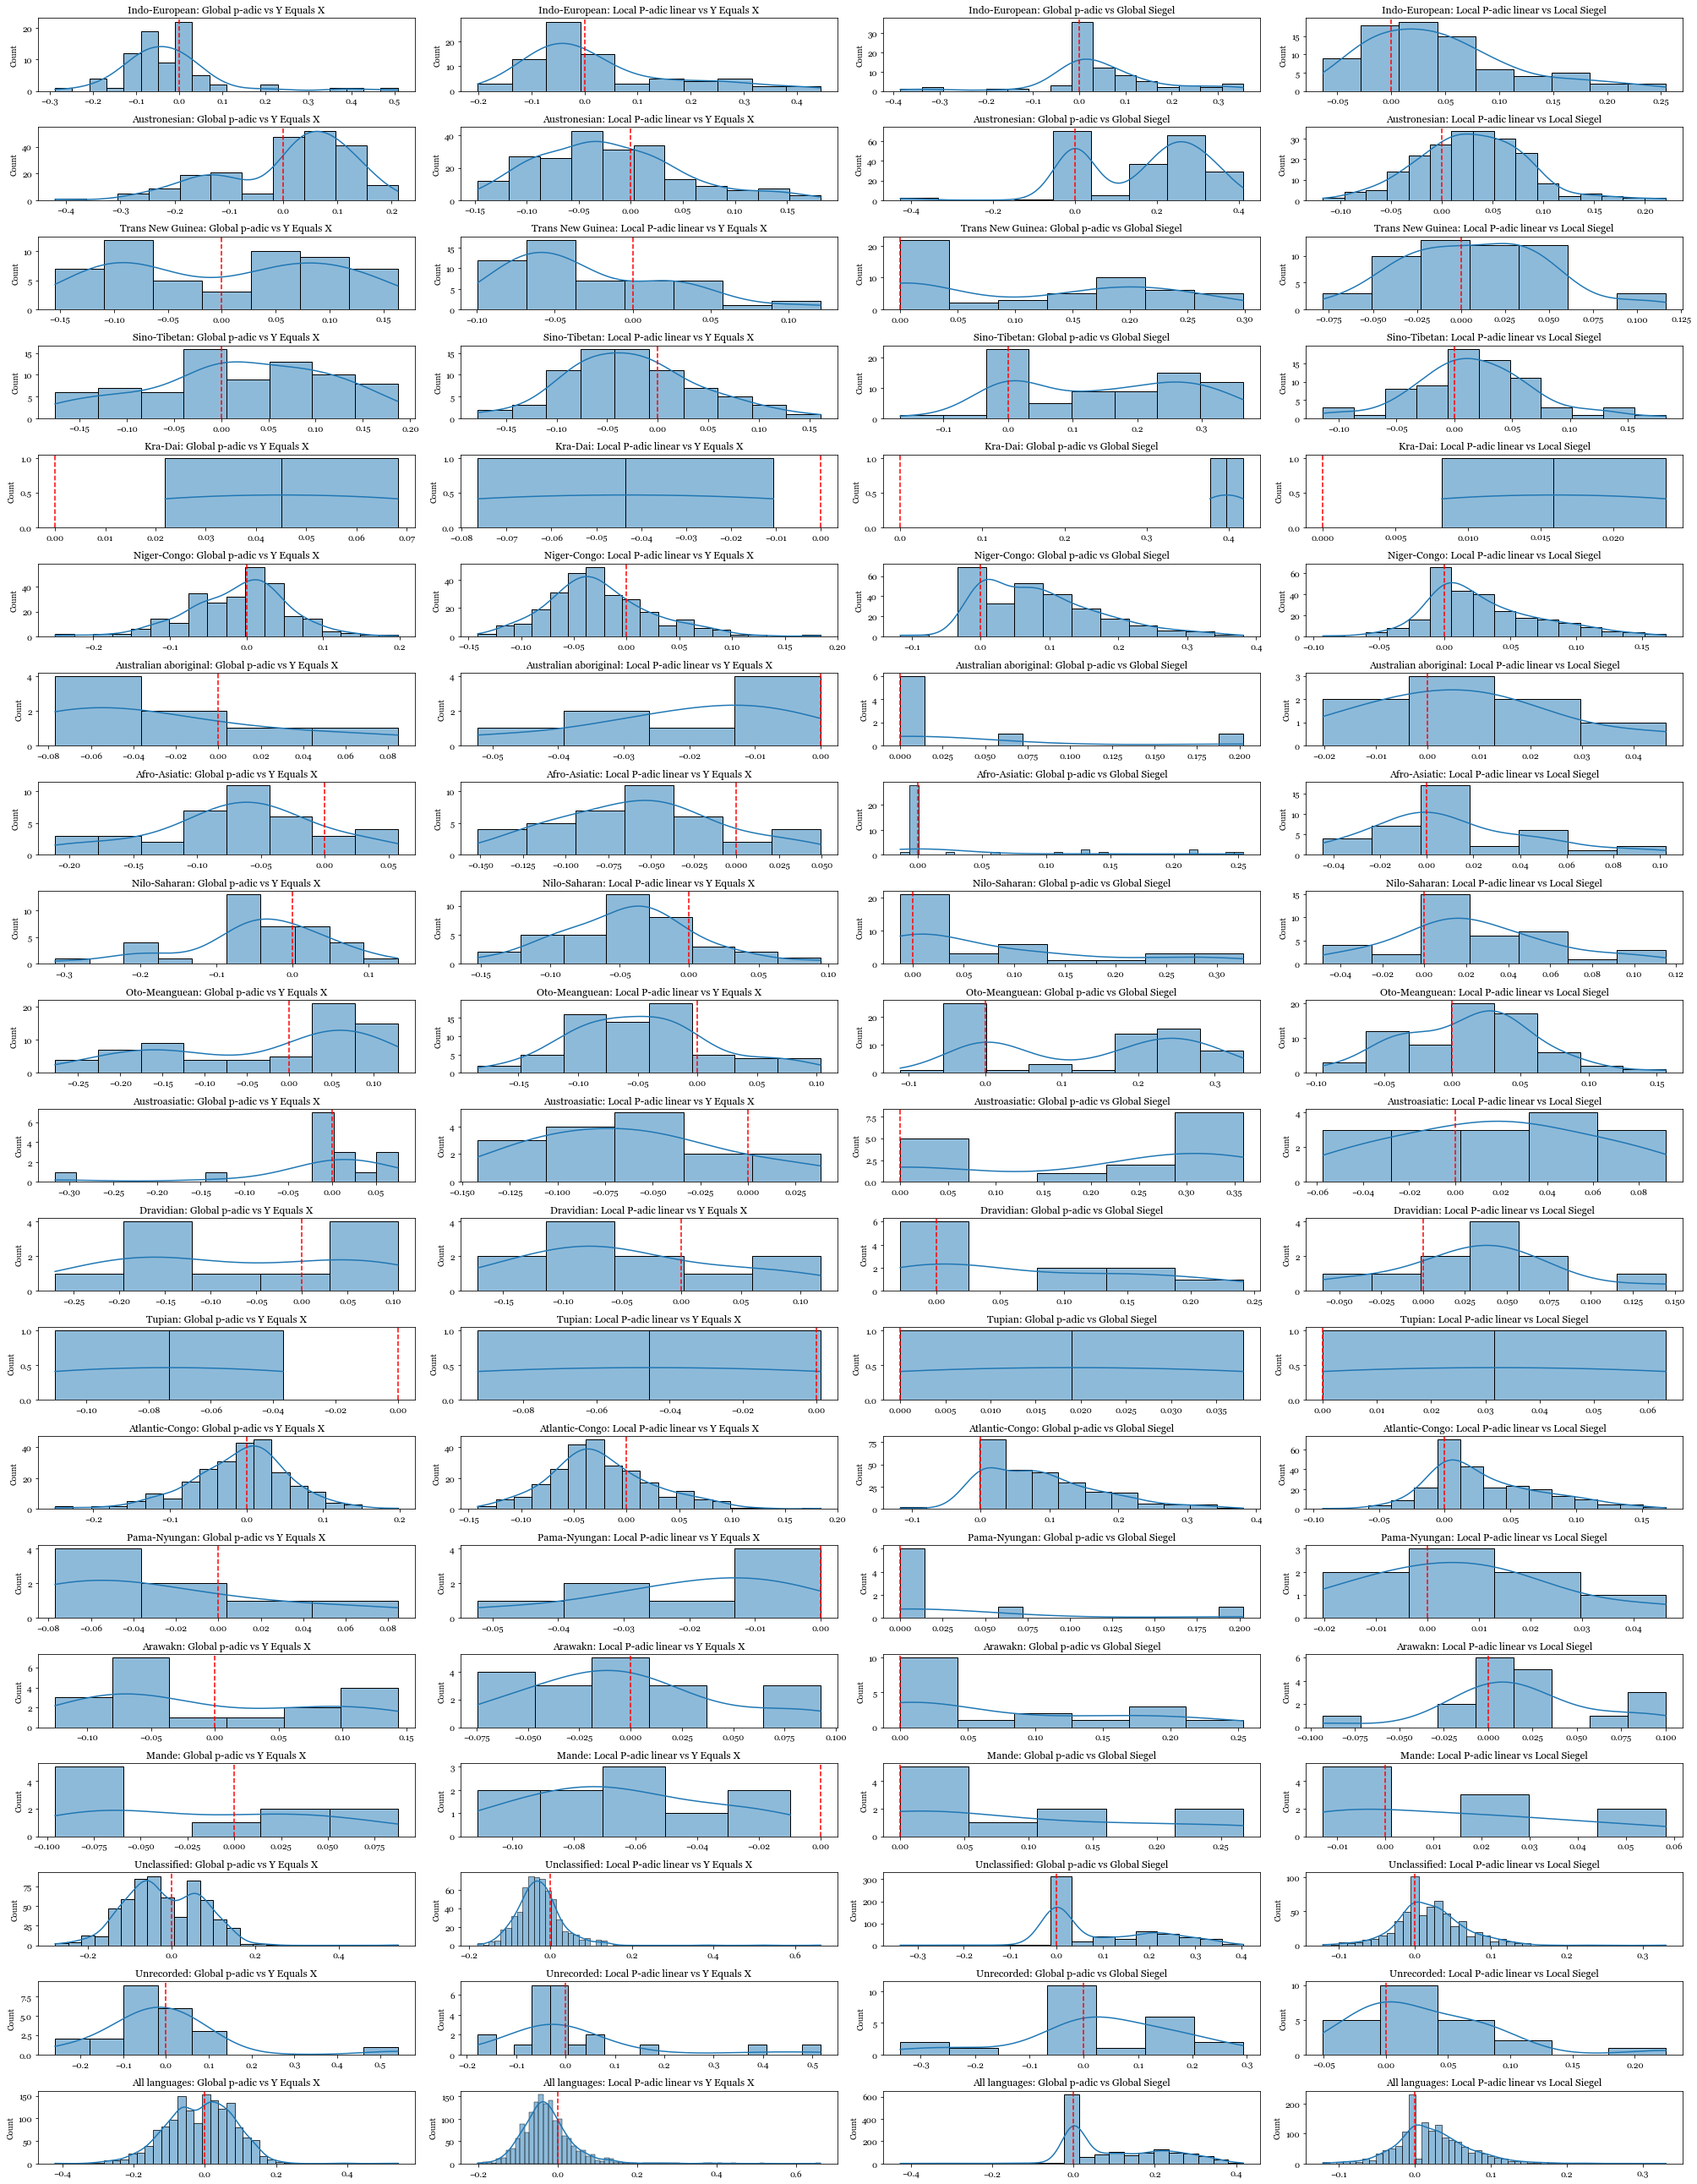

In [29]:
diffs = []
fig, axes = matplotlib.pyplot.subplots(
    figsize=(7*len(comparison_pairs), 1.8*len(language_family_columns+extra_families)),
    nrows=len(language_family_columns+extra_families),
    ncols=len(comparison_pairs)
)
for i, family in enumerate(language_family_columns + extra_families):
    for j, comparison in enumerate(comparison_pairs):
        l,r = comparison
        subset = by_language[by_language[family]]
        diff = subset[l] - subset[r]
        seaborn.histplot(data=diff, ax=axes[i][j], kde=True)
        #axes[i][j].hist(diff)
        axes[i][j].axvline(0, color="red", linestyle="--")
        axes[i][j].set_title(f"{nice_language_family_names[family]}: {metric_renaming[l]} vs {metric_renaming[r]}")
fig.tight_layout()
fig.savefig("experiment-diffs-not-normal.png")

In [16]:
language_p_values = []
for family in language_family_columns + extra_families:
    record = {'family': nice_language_family_names[family] }
    for comparison in comparison_pairs:
        l,r = comparison
        subset = by_language[by_language[family]]
        p = scipy.stats.wilcoxon(subset[l], subset[r], alternative='greater', zero_method='pratt').pvalue
        record[f"{metric_renaming[l]} vs {metric_renaming[r]}"] = p
    language_p_values.append(record)
language_p_values = pandas.DataFrame.from_records(language_p_values).set_index('family')
corrected_p_values = language_p_values.applymap(bonferroni)
language_p_values

/Users/gregb/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/gregb/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Global p-adic vs Y Equals X,Local P-adic linear vs Y Equals X,Global p-adic vs Global Siegel,Local P-adic linear vs Local Siegel
family,,,,
Indo-European,0.999759,0.508610,5.497745e-06,1.678691e-07
Austronesian,0.015532,0.999999,1.294805e-27,1.721462e-13
Trans New Guinea,0.421058,0.999878,1.977290e-08,8.838064e-02
Sino-Tibetan,0.035625,0.999526,3.145845e-11,1.863858e-03
Kra-Dai,0.250000,1.000000,2.500000e-01,2.500000e-01
Niger-Congo,0.974884,1.000000,1.441571e-39,5.105794e-23
Australian aboriginal,0.875000,0.992985,7.911032e-02,1.783828e-01
Afro-Asiatic,0.999999,0.999999,2.633454e-03,5.921484e-02
Nilo-Saharan,0.995480,0.999987,3.560059e-05,2.591979e-04


In [17]:
corrected_p_values

,Global p-adic vs Y Equals X,Local P-adic linear vs Y Equals X,Global p-adic vs Global Siegel,Local P-adic linear vs Local Siegel
family,,,,
Indo-European,1.000000,1.0,4.397241e-04,1.342944e-05
Austronesian,0.714148,1.0,0.000000e+00,1.377565e-11
Trans New Guinea,1.000000,1.0,1.581831e-06,9.993903e-01
Sino-Tibetan,0.945085,1.0,2.516680e-09,1.386443e-01
Kra-Dai,1.000000,1.0,1.000000e+00,1.000000e+00
Niger-Congo,1.000000,1.0,0.000000e+00,0.000000e+00
Australian aboriginal,1.000000,1.0,9.986304e-01,9.999999e-01
Afro-Asiatic,1.000000,1.0,1.901889e-01,9.924275e-01
Nilo-Saharan,1.000000,1.0,2.844046e-03,2.052495e-02


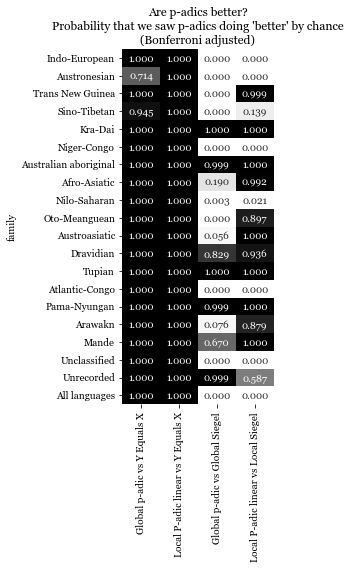

In [42]:
fig, ax = matplotlib.pyplot.subplots(figsize=(4,8))
seaborn.heatmap(corrected_p_values, annot=True, ax=ax, fmt='.3f', cmap="Greys", cbar=False)
ax.set_title("Are p-adics better?\nProbability that we saw p-adics doing 'better' by chance\n(Bonferroni adjusted)",
            )
fig.tight_layout()
fig.savefig("p-adic-experimental-results.png", dpi=200)

<AxesSubplot:ylabel='family'>

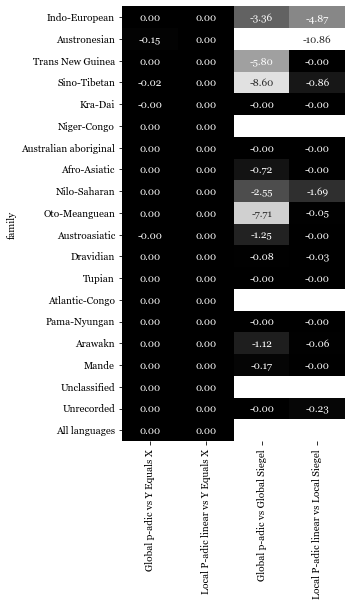

In [39]:
fig, ax = matplotlib.pyplot.subplots(figsize=(4,8))
seaborn.heatmap(corrected_p_values.applymap(lambda x: math.log10(x) if x > 0 else numpy.nan), annot=True,
                fmt='.2f', ax=ax,
               cmap="Greys", cbar=False)

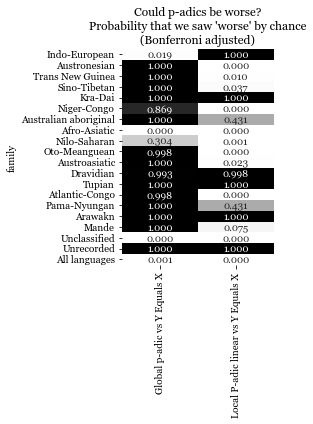

In [45]:
reverse_comparison_pairs = [
    ( 'global_padic_linear_proportion_correct', 'y_equals_x_proportion_correct'),
    ('local_padic_linear_proportion_correct', 'y_equals_x_proportion_correct')]
reversed_language_p_values = []
for family in language_family_columns + extra_families:
    record = {'family': nice_language_family_names[family] }
    for comparison in reverse_comparison_pairs:
        l,r = comparison
        subset = by_language[by_language[family]]
        p = scipy.stats.wilcoxon(subset[l], subset[r], alternative='less', zero_method='pratt').pvalue
        record[f"{metric_renaming[l]} vs {metric_renaming[r]}"] = p
    reversed_language_p_values.append(record)
reversed_language_p_values = pandas.DataFrame.from_records(reversed_language_p_values).set_index('family')
corrected_reversed_p_values = reversed_language_p_values.applymap(bonferroni)
corrected_reversed_p_values
fig, ax = matplotlib.pyplot.subplots(figsize=(4,6))
seaborn.heatmap(corrected_reversed_p_values, annot=True, ax=ax, fmt='.3f', cmap="Greys", cbar=False)
ax.set_title("Could p-adics be worse?\nProbability that we saw 'worse' by chance\n(Bonferroni adjusted)")
fig.tight_layout()
fig.savefig('reverse-padic-experiment.png')

In [21]:
subset = by_language[~by_language.afro_asiatic & ~by_language.unclassified & ~by_language.unrecorded]
scipy.stats.wilcoxon(subset.global_padic_linear_proportion_correct, 
                     subset.y_equals_x_proportion_correct, alternative='less', zero_method='pratt')

WilcoxonResult(statistic=176180.5, pvalue=0.23897547056728324)

In [22]:
scipy.stats.wilcoxon(subset.local_padic_linear_proportion_correct, 
                     subset.y_equals_x_proportion_correct, alternative='less', zero_method='pratt')

WilcoxonResult(statistic=96753.0, pvalue=1.5535200207174447e-32)

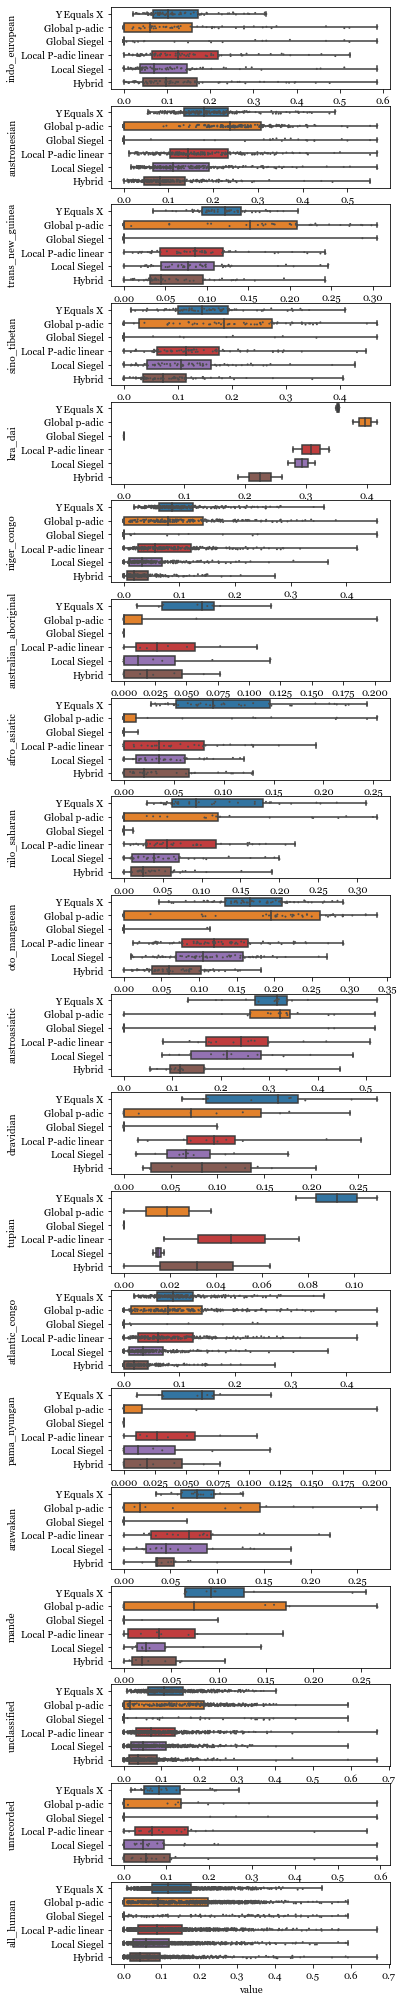

In [47]:
nrows = len(language_family_columns + extra_families)
fig, axes = matplotlib.pyplot.subplots(figsize=(5, 1.8*nrows), nrows=nrows)
for which, family in enumerate(language_family_columns + extra_families):
    ax = axes[which]
    #data_for_this_family = by_language[by_language[family]]
    #box_plot_data = []
    #labels = []
    #means = []
    #for m in reversed(metrics):
    #    labels.append(metric_renaming.get(m,m))
    #    data_for_this_metric = data_for_this_family[m]
    #    box_plot_data.append(data_for_this_metric)
    #    means.append(data_for_this_metric.mean())
    #means = pandas.Series(means)
    #normaliser = matplotlib.colors.Normalize(means.min(), means.max())
    #normalised_means = means.map(normaliser)
    #colors = [colorscheme(x) for x in normalised_means]
    #bplot = ax.boxplot(box_plot_data,
    #                   vert=False,
    #                          labels=labels,
    #                          patch_artist=True,
    #                         )
    #for patch, color in zip(bplot['boxes'], colors):
    #    patch.set_facecolor(color)
    df = renamed[renamed[family]].melt(id_vars='language', 
                 value_vars=renamed_metrics, var_name=family)
    seaborn.stripplot(x="value", y=family, data=df, ax=ax,
              size=2, color=".3", linewidth=0)
    seaborn.boxplot(x="value", y=family, data=df, ax=ax,
            whis=[0, 100], width=.6)


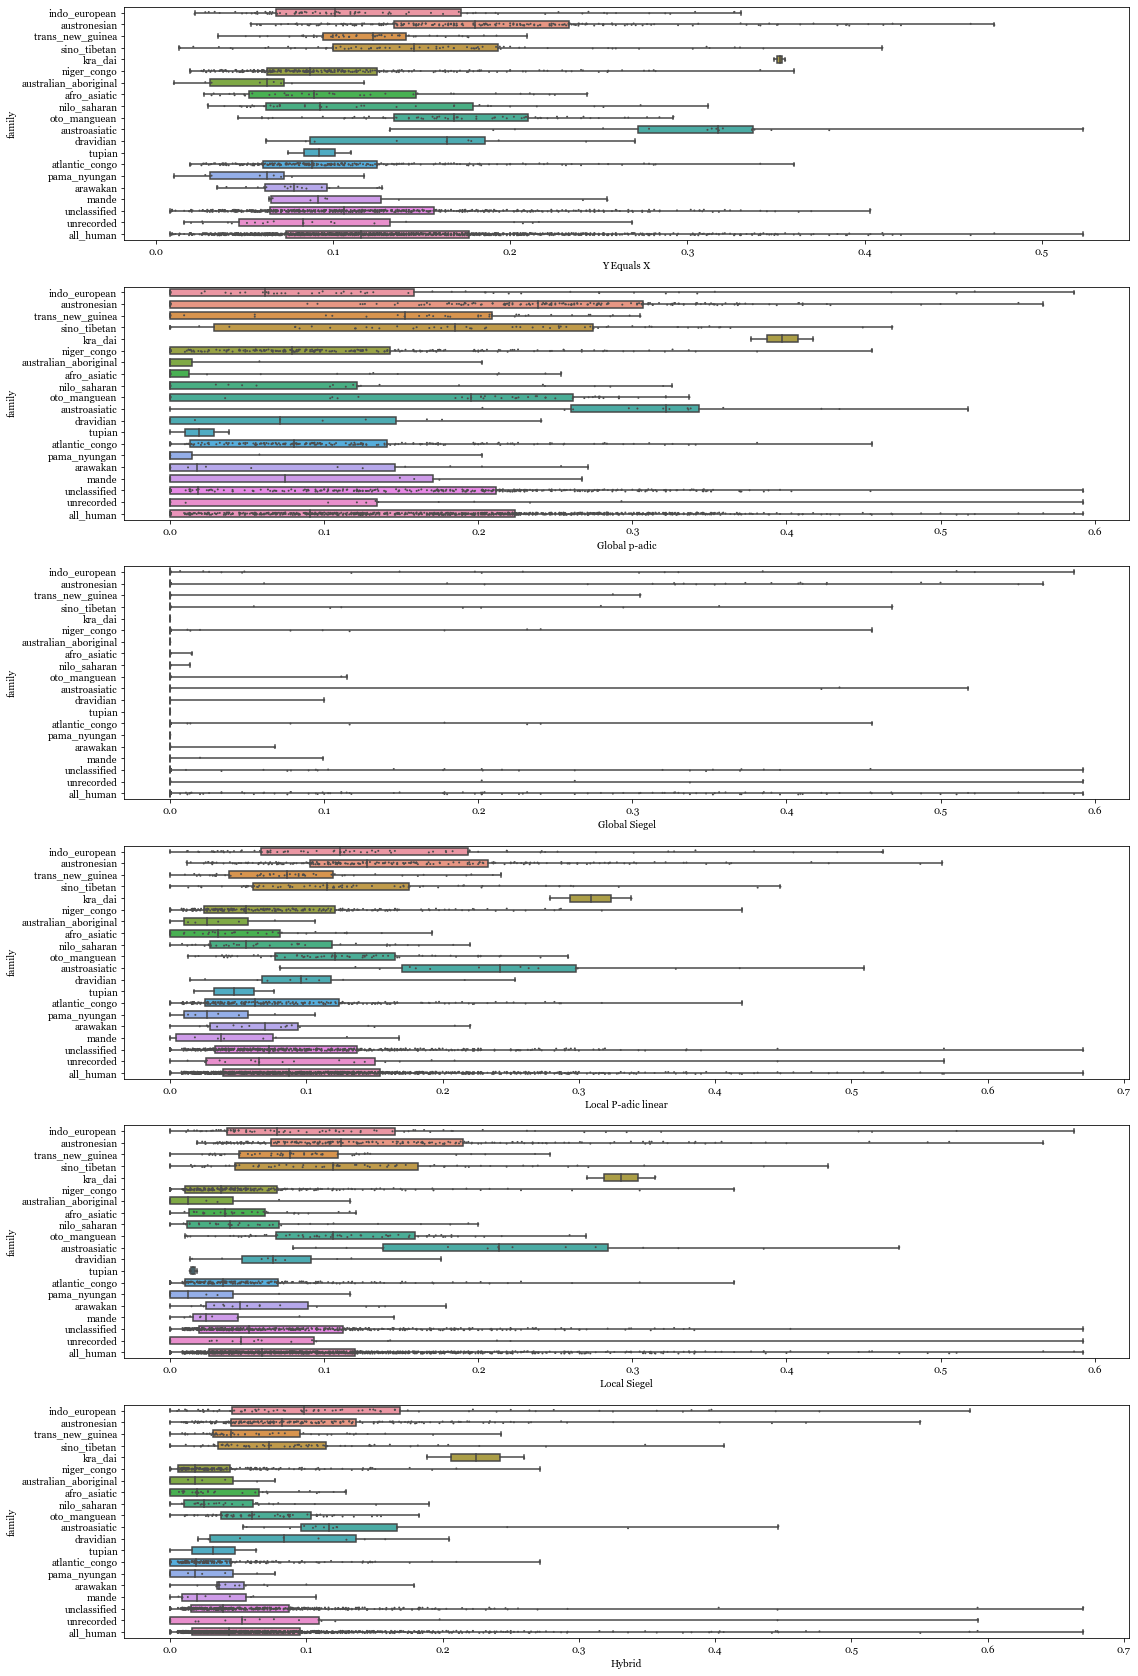

In [24]:
side_melts = []
for language in language_family_columns + extra_families:
    this_language = by_language[by_language[language]][['language']]
    for metric in metrics:
        this_language[metric] = by_language[by_language[language]][metric]
    this_language['family'] = language
    side_melts.append(this_language)
side_melts = pandas.concat(side_melts)

nrows = len(metrics)
fig, axes = matplotlib.pyplot.subplots(figsize=(18, 5*nrows), nrows=nrows)
for which, metric in enumerate(metrics):
    ax = axes[which]
    seaborn.boxplot(x=metric, y="family", data=side_melts, ax=ax,
            whis=[0, 100], width=.6)
    seaborn.stripplot(x=metric, y="family", data=side_melts, ax=ax,
              size=2, color=".3", linewidth=0)
    ax.set_xlabel(metric_renaming.get(metric,metric))

In [25]:
side_melts

,language,y_equals_x_proportion_correct,global_padic_linear_proportion_correct,global_siegel_proportion_correct,local_padic_linear_proportion_correct,local_euclidean_siegel_proportion_correct,hybrid_siegel_proportion_correct,family
0,eng,0.114286,0.510417,0.510417,0.489583,0.510417,0.476562,indo_european
15,afr,0.142857,0.154639,0.000000,0.247423,0.134021,0.164948,indo_european
84,awa,0.171053,0.092105,0.000000,0.039474,0.039474,0.024096,indo_european
136,bhd,0.128205,0.000000,0.000000,0.086420,0.049383,0.024691,indo_european
155,bdv,0.191781,0.191781,0.000000,0.150685,0.054795,0.126316,indo_european
...,...,...,...,...,...,...,...,...
1492,crl,0.147059,0.000000,0.000000,0.044118,0.044118,0.044118,all_human
1493,caf,0.127451,0.202532,0.000000,0.126582,0.113924,0.050633,all_human
1494,hak,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,all_human
1495,zho,0.035714,0.000000,0.000000,0.000000,0.014388,0.000000,all_human


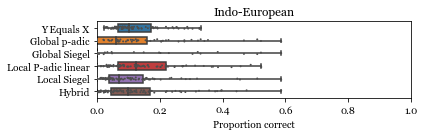

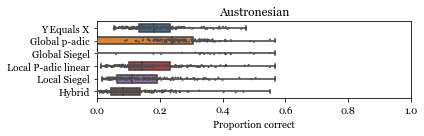

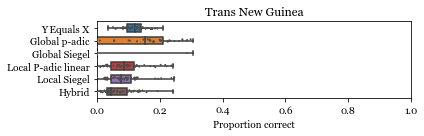

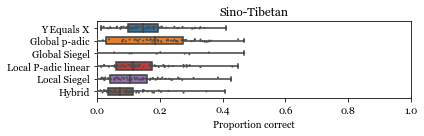

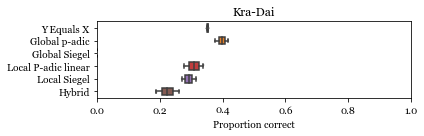

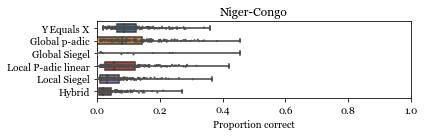

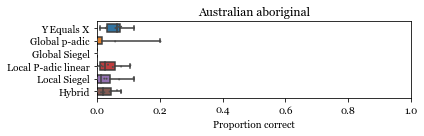

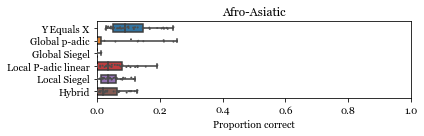

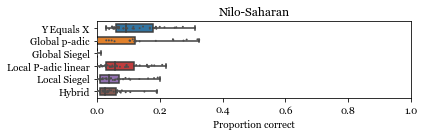

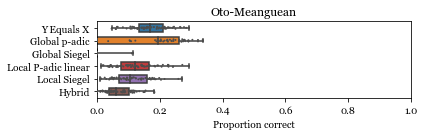

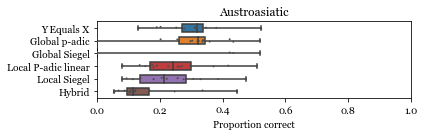

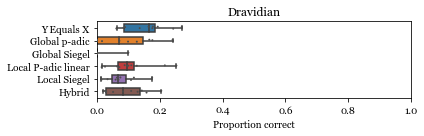

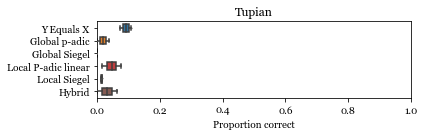

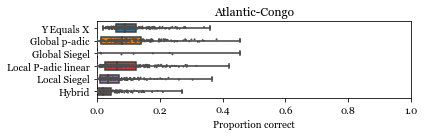

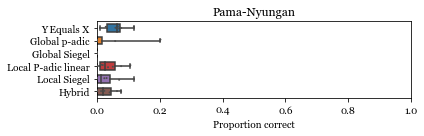

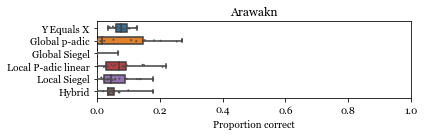

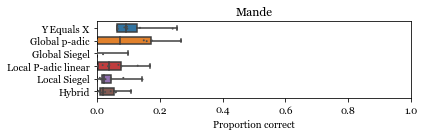

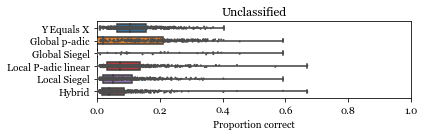

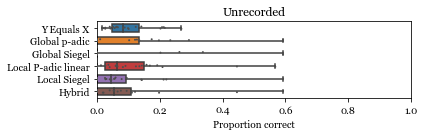

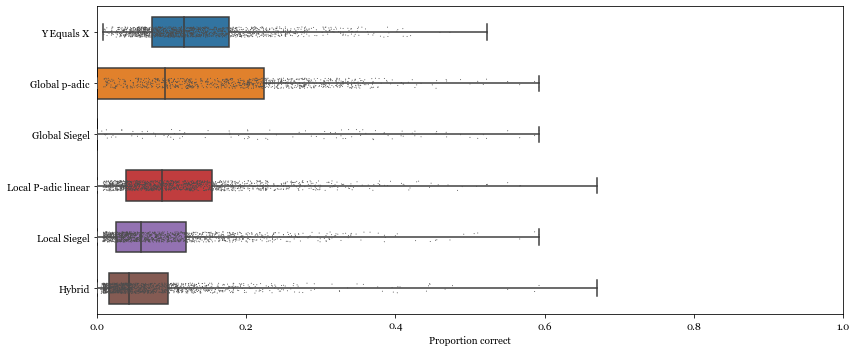

In [26]:
os.makedirs('family-metric-charts', exist_ok=True)
for which, family_code in enumerate(language_family_columns + extra_families):
    family = nice_language_family_names[family_code]
    if family == 'All languages':
        fig, ax = matplotlib.pyplot.subplots(figsize=(12, 5))
    else:
        fig, ax = matplotlib.pyplot.subplots(figsize=(6, 2))
    df = renamed[renamed[family_code]].melt(id_vars='language', 
                 value_vars=renamed_metrics, var_name=family)
    seaborn.stripplot(x="value", y=family, data=df, ax=ax,
              size=2 if family != 'All languages' else 1, color=".3", linewidth=0)
    seaborn.boxplot(x="value", y=family, data=df, ax=ax,
            whis=[0, 100], width=.6)
    if family != 'All languages':
        ax.set_title(family)
    ax.set_ylabel("")
    ax.set_xlabel("Proportion correct")
    ax.set_xlim(0,1)
    fig.tight_layout()
    fig.savefig(f"family-metric-charts/family-metric-chart-{family_code}.png")

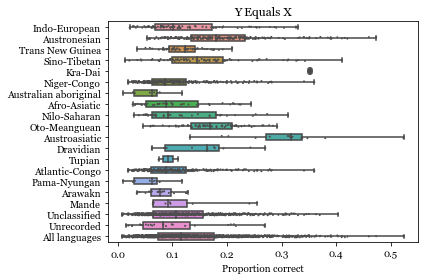

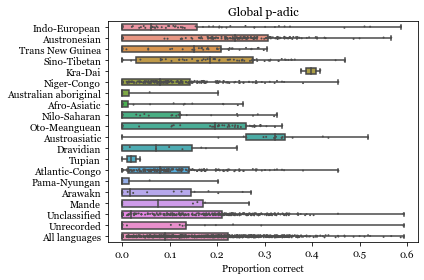

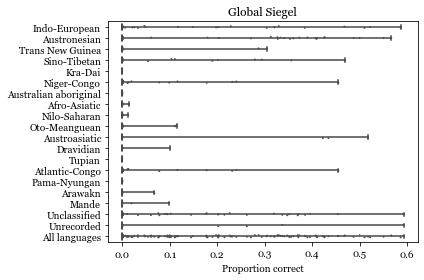

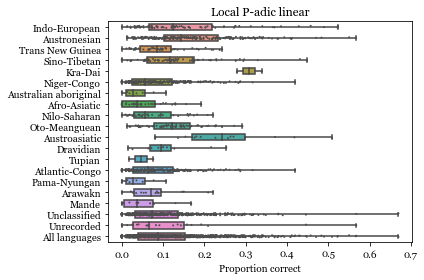

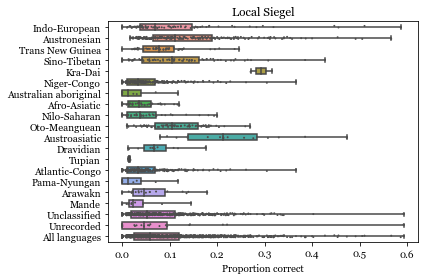

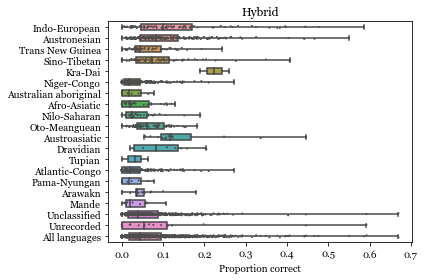

In [51]:
os.makedirs("metric-family-charts", exist_ok=True)
side_melts['family_name'] = side_melts.family.map(nice_language_family_names)

for which, metric in enumerate(metrics):
    fig, ax = matplotlib.pyplot.subplots(figsize=(6, 4))
    seaborn.boxplot(x=metric, y="family_name", data=side_melts, ax=ax,
            whis=[0, 100], width=.6)
    seaborn.stripplot(x=metric, y="family_name", data=side_melts, ax=ax,
              size=2, color=".3", linewidth=0)
    ax.set_xlabel("Proportion correct")
    ax.set_title(metric_renaming.get(metric,metric))
    ax.set_ylabel("")
    fig.tight_layout()
    fig.savefig(f"metric-family-charts/metric-family-chart-{metric}.png", dpi=200)

In [28]:
number_of_experiments

80